# Technical Details

In [1]:
# Dependencies
from typing import List, Tuple, Dict, Callable
import copy
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
torch.autograd.anomaly_mode.set_detect_anomaly(True)

import torch_geometric as pyg

import pygmtools as pygm
pygm.set_backend('pytorch')

import D4Explainer

c:\Users\Admin\anaconda3\envs\SuperTest2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Meta Data

# Reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True 
np.random.seed(SEED)

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Variables. 
max_num_nodes = 30 # 28 in the full dataset.  
batch_size = 64
color_palette = np.array(['orange', 'magenta', 'green', 'blue', 'cyan', 'red', 'lime'])

Using device: cuda


## MUTAG Data  

In [3]:
# Download data. 
from torch_geometric.datasets import TUDataset
data_raw = TUDataset(root='data/TUDataset', name='MUTAG')

# Shuffle.
data_raw = data_raw.shuffle()

# Split.
train_data = data_raw[:150]
test_data = data_raw[150:]

def preprocess_MUTAG(data: TUDataset, max_num_nodes) -> pyg.data.Data:
    
    num_nodes = data.num_nodes
    
    # Pad node features.
    padded_x = torch.zeros((max_num_nodes, data.x.size(1)))
    padded_x[:num_nodes] = data.x

    # Relax edges to weights. 
    padded_adj = torch.zeros((max_num_nodes, max_num_nodes))
    padded_adj[:num_nodes, :num_nodes] = (
        pyg.utils.to_dense_adj(data.edge_index).squeeze(0)
    )
    edge_index, edge_weight = pygm.utils.dense_to_sparse(padded_adj + 1)
    edge_index = edge_index.transpose(0, 1)
    edge_weight = edge_weight.squeeze(0)

    # Wrap in data object.
    preprocessed_data = pyg.data.Data(x=padded_x, 
                                      edge_index=edge_index,
                                      edge_attr=edge_weight - 1,
                                      y=data.y)

    return preprocessed_data 

# Create data lists.
train_data_list = []
train_data_list_0 = []
train_data_list_1 = []
test_data_list = []
test_data_list_0 = []
test_data_list_1 = []

for graph in train_data:
    train_data_list.append(preprocess_MUTAG(graph, max_num_nodes))

    if graph.y.item() == 0: 
        train_data_list_0.append(preprocess_MUTAG(graph, max_num_nodes))

    elif graph.y.item() == 1: 
        train_data_list_1.append(preprocess_MUTAG(graph, max_num_nodes))

for graph in test_data:
    test_data_list.append(preprocess_MUTAG(graph, max_num_nodes))

    if graph.y.item() == 0: 
        test_data_list_0.append(preprocess_MUTAG(graph, max_num_nodes))

    elif graph.y.item() == 1: 
        test_data_list_1.append(preprocess_MUTAG(graph, max_num_nodes))

# Create data loaders.
train_loader = pyg.loader.DataLoader(train_data_list, batch_size=batch_size, 
                                     shuffle=True)
test_loader = pyg.loader.DataLoader(test_data_list, batch_size=batch_size, 
                                    shuffle=True)

In [4]:
def clean_graph(gen: pyg.data.Data) -> pyg.data.Data: 
    """
    Removes zero padding, self loops and isolated nodes. 
    """
    edge_index = gen.edge_index

    edge_index, edge_attr = pyg.utils.remove_self_loops(edge_index)

    gen.edge_index, gen.edge_attr, mask = (
        pyg.utils.remove_isolated_nodes(edge_index, num_nodes=gen.x.shape[0])
    )

    # Zero node features if all cleared. 
    if gen.x[mask].shape[0] == 0:
        gen.x = gen.x * 0.0
    else: 
        gen.x = gen.x[mask]

    # # Remove zero nodes. 
    # zero_mask = gen.x.sum(dim=1) == 0
    # gen.x = gen.x[zero_mask]

    # # Create a mapping from old node indices to new node indices
    # new_index = torch.zeros(gen.num_nodes, dtype=torch.long)
    # new_index[zero_mask] = torch.arange(zero_mask.sum())

    # # Filter edges
    # edge_mask = zero_mask[gen.edge_index[0]] & zero_mask[gen.edge_index[1]]
    # gen.edge_index = gen.edge_index[:, edge_mask]

    # # Re-index edges
    # gen.edge_index = new_index[gen.edge_index]

    cleaned = pyg.data.Batch(
        x=gen.x, 
        edge_index=gen.edge_index, 
        batch=gen.batch
    )

    return cleaned

def graph_to_nx(graph: pyg.data.Batch) -> nx.Graph:
    
    graph.edge_index = pygm.utils.dense_to_sparse(
        graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
    )[0].transpose(0, 1)
    graph = clean_graph(graph)
    graph_colors = color_palette[torch.argmax(graph.x, dim=1)]
    graph_nx = pyg.utils.to_networkx(graph)

    return graph_nx

In [5]:
# Chat-GPT
def to_data_list(batch: pyg.data.Batch) -> List[pyg.data.Data]:
    data_list = []
    for i in range(batch.batch.max().item() + 1):
        node_mask = batch.batch == i
        edge_mask = node_mask[batch.edge_index[0]] & node_mask[batch.edge_index[1]]
        
        if node_mask.nonzero(as_tuple=False).numel() > 0:  # Ensure there are nodes in the mask
            node_indices = node_mask.nonzero(as_tuple=False).view(-1)
            edge_index = batch.edge_index[:, edge_mask]
            
            # Map edge indices to the new range
            if edge_index.numel() > 0:  # Ensure there are edges in the mask
                edge_index = edge_index - node_indices.min()
            
            data = pyg.data.Data(
                x=batch.x[node_mask],
                edge_index=edge_index
            )
            data_list.append(data)
    
    return data_list

## Explainee GCN Model

In [6]:
class GCNWeighted(nn.Module):
    def __init__(self, hidden_channels):
        super(GCNWeighted, self).__init__()
        self.conv1 = pyg.nn.GCNConv(7, hidden_channels) # 7 node features.
        self.conv2 = pyg.nn.GCNConv(hidden_channels, hidden_channels)
        self.conv3 = pyg.nn.GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 2) # 2 classes.
    
    def forward(self, data):
        x, edge_index, batch, edge_weight = (
            data.x, data.edge_index, data.batch, data.edge_attr
        )

        # 1. Node embeddings.
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight)

        # 2. Pooling.
        x = pyg.nn.global_mean_pool(x, batch)

        # 3. Prediction.
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [7]:
# Training Explainee.
explainee = GCNWeighted(hidden_channels=64)
optimizer = torch.optim.Adam(explainee.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(data_loader): 
    explainee.train()

    for batch in data_loader: 
        out = explainee(batch)
        loss = criterion(out, batch.y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

def explainee_accuracy(data_loader):
    explainee.eval()

    correct = 0
    for batch in data_loader: 
        out = explainee(batch)
        pred = out.argmax(dim=1)
        correct += int((pred == batch.y).sum())

    return correct / len(data_loader.dataset)

for epoch in range(1, 201): 
    train(train_loader)
    train_accuracy = explainee_accuracy(train_loader)
    test_accuracy = explainee_accuracy(test_loader)

    print(f"Epoch: {epoch} Train Accuracy: {train_accuracy} " + 
          f"Test Accuracy: {test_accuracy}")

Epoch: 1 Train Accuracy: 0.6533333333333333 Test Accuracy: 0.7105263157894737
Epoch: 2 Train Accuracy: 0.6533333333333333 Test Accuracy: 0.7105263157894737
Epoch: 3 Train Accuracy: 0.6533333333333333 Test Accuracy: 0.7105263157894737
Epoch: 4 Train Accuracy: 0.6533333333333333 Test Accuracy: 0.7105263157894737
Epoch: 5 Train Accuracy: 0.6533333333333333 Test Accuracy: 0.7105263157894737
Epoch: 6 Train Accuracy: 0.6533333333333333 Test Accuracy: 0.7105263157894737
Epoch: 7 Train Accuracy: 0.68 Test Accuracy: 0.7105263157894737
Epoch: 8 Train Accuracy: 0.7066666666666667 Test Accuracy: 0.7631578947368421
Epoch: 9 Train Accuracy: 0.7133333333333334 Test Accuracy: 0.7631578947368421
Epoch: 10 Train Accuracy: 0.7333333333333333 Test Accuracy: 0.8157894736842105
Epoch: 11 Train Accuracy: 0.82 Test Accuracy: 0.8421052631578947
Epoch: 12 Train Accuracy: 0.82 Test Accuracy: 0.8421052631578947
Epoch: 13 Train Accuracy: 0.78 Test Accuracy: 0.8421052631578947
Epoch: 14 Train Accuracy: 0.8266666666

In [8]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

full_batch = pyg.data.Batch.from_data_list(test_data_list + train_data_list)
explainee.eval()
preds = explainee(full_batch).argmax(dim=1).numpy()
targets = full_batch.y.numpy()

conf_matrix = confusion_matrix(targets, preds)
conf_matrix

array([[ 46,  17],
       [ 10, 115]], dtype=int64)

In [9]:
def activation_hook(model: nn.Module,
                    layer_names: List[str]) -> Tuple[Dict[str, torch.Tensor], 
                                                     Callable]:
    """
    Establishes forward hooks to extract a names activations from a model. 
    Returns a dictionary of activations and a function to remove the hooks.
    """
    activations = {}

    def hook(module, input, output, name):
        activations[name] = output #.detach()

    hooks = []
    for name, module in model.named_modules():
        if name in layer_names:
            hook_fn = (
                lambda module, input, output, name=name: 
                    hook(module, input, output, name)
            )
            hooks.append(module.register_forward_hook(hook_fn))

    def remove_hooks():
        for hook in hooks:
            hook.remove()

    return activations, remove_hooks

# Extract Average embeddings. 
activation_names = ["conv3"]
train_avg_embedding_0 = {"conv3": []}
train_avg_embedding_1 = {"conv3": []}
pool_func = pyg.nn.global_mean_pool

train_loader_b1 = pyg.loader.DataLoader(train_data_list, batch_size=1)
for batch in train_loader_b1:
    explainee.eval()

    acts, remove_hooks = activation_hook(explainee, activation_names)
    out = explainee(batch)
    remove_hooks()

    if batch.y.item() == 0: 
        for name in activation_names: 
            embed = pool_func(acts[name], batch.batch)
            train_avg_embedding_0[name].append(
                embed.detach().to('cpu')
            )

    if batch.y.item() == 1: 
        for name in activation_names: 
            embed = pool_func(acts[name], batch.batch)
            train_avg_embedding_1[name].append(
                embed.detach().to('cpu')
            )
            
for name in activation_names:
    train_avg_embedding_0[name] = torch.stack(
        train_avg_embedding_0[name]
    ).mean(dim=0)

    train_avg_embedding_1[name] = torch.stack(
        train_avg_embedding_1[name]
    ).mean(dim=0)

print(train_avg_embedding_0)
print(train_avg_embedding_1)

{'conv3': tensor([[ 0.0433,  0.0892, -0.0691,  0.2047, -0.0546,  0.0133,  0.0233,  0.0281,
         -0.0197,  0.0185, -0.0304, -0.0282,  0.0609, -0.1973, -0.0363, -0.0563,
          0.1371, -0.0039,  0.1190, -0.0557, -0.0141,  0.0619, -0.0345,  0.1199,
          0.0246,  0.0102, -0.0339,  0.0140,  0.0086, -0.0420, -0.1842, -0.0389,
          0.0522,  0.1159,  0.0328, -0.0540,  0.0025,  0.0096,  0.0605,  0.0052,
         -0.0324, -0.0703,  0.0821, -0.0207, -0.1181, -0.1058, -0.0271,  0.1257,
         -0.0125,  0.0385,  0.0893,  0.0032, -0.0102, -0.0461,  0.0350,  0.1164,
         -0.0875,  0.0088, -0.0928,  0.0114,  0.0153,  0.1764,  0.0349,  0.0270]])}
{'conv3': tensor([[ 0.0741, -0.0978,  0.0987,  0.1373, -0.2566, -0.1512, -0.1541,  0.2222,
          0.1364, -0.0474, -0.2122,  0.1377, -0.1266, -0.0542, -0.2206, -0.2309,
          0.3616, -0.1536,  0.0045,  0.1176,  0.1576,  0.2886,  0.1486,  0.0492,
         -0.1540, -0.1284, -0.2096, -0.1653, -0.1275,  0.1075, -0.0622, -0.2044,
     

## D4Explainer 

In [10]:
# Hyperparameters.
T = 50
time_embed_dim = 10
num_node_feats = 7

betas = torch.linspace(start=0.001, end=0.1, steps=T)
beta_bars = []
cum_prod = 1

for beta in betas:
    cum_prod *= (1 - 2*beta)
    beta_bars.append(0.5 - 0.5 * cum_prod)

num_epochs = 200

In [11]:
def forward_diffusion_sample(graphs: pyg.data.Batch, 
                             t: int) -> pyg.data.Batch:
    """
    Input: Batch of observed graphs.
    Output: Batch of noised graphs.
    """
    edge_weight = graphs.edge_attr

    transition_probs = torch.full_like(edge_weight, beta_bars[t])
    transition_dist = torch.distributions.RelaxedBernoulli(
        temperature=0.15, probs=transition_probs
    )

    noised_edge_weights = torch.abs(
        edge_weight + transition_dist.rsample()
    )
    
    noised_graph = pyg.data.Batch(x=graphs.x, 
                                  edge_index=graphs.edge_index,
                                  edge_attr=noised_edge_weights,  
                                  y=graphs.y, batch=graphs.batch)

    return noised_graph

In [12]:
class denoising_model(nn.Module):
    def __init__(self, T, time_embed_dim, 
                 num_node_feats, h1=10, h2=50, h3=30, p_dropout=0.5): 
        super(denoising_model, self).__init__()

        self.time_embedder = nn.Embedding(num_embeddings=T, 
                                          embedding_dim=time_embed_dim) 

        self.conv1 = pyg.nn.GCNConv(num_node_feats, h1)
        self.conv2 = pyg.nn.GCNConv(h1, h2)
        self.conv3 = pyg.nn.GCNConv(h2, h3)

        self.p_dropout = p_dropout
        self.lin = nn.Linear(h3, max_num_nodes**2) # predicting weights.

    def forward(self, noised_graphs, t):
        
        x, edge_index, batch, edge_weight = (
            noised_graphs.x, noised_graphs.edge_index, 
            noised_graphs.batch, noised_graphs.edge_weight
        )

        time_embedding = self.time_embedder(t)

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.p_dropout)
        
        x = x + time_embedding
        
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.p_dropout)

        x = self.conv3(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.p_dropout)

        x = pyg.nn.global_mean_pool(x, batch)
        x = F.dropout(x, p=self.p_dropout)
        x = self.lin(x)
        x = F.sigmoid(x) 

        pred_weights = x.reshape(-1)
        pred_graph = pyg.data.Batch(x=noised_graphs.x, 
                                    edge_index=noised_graphs.edge_index,
                                    edge_attr=pred_weights,
                                    batch=noised_graphs.batch)
    
        return [pred_weights, pred_graph]

In [13]:
# Training Loop.
model_denoise_CF = denoising_model(T, time_embed_dim=time_embed_dim, 
                                num_node_feats=num_node_feats) 

optimizer = torch.optim.Adam(model_denoise_CF.parameters(), lr=0.001)
CF_weight = 0.5

for epoch in range(1, num_epochs): 
    running_loss_dist = 0.0
    running_loss_CF = 0.0
    for graphs in train_loader:
        with torch.no_grad():
            t = torch.randint(low=1, high=T, size=(1,))
            noised_graphs = forward_diffusion_sample(graphs, t)

        pred_weight, pred_graph = model_denoise_CF(noised_graphs, t)

        loss_dist = F.binary_cross_entropy(
            pred_weight, graphs.edge_attr.squeeze(1)
        )  
        running_loss_dist += loss_dist.item()

        explainee.eval()
        explainee_pred = F.softmax(explainee(pred_graph), dim=-1)
        class_prob = explainee_pred[torch.arange(explainee_pred.shape[0]), 
                                    graphs.y]
        loss_CF = (-1 * torch.log(1 - class_prob)).mean()
        running_loss_CF += loss_CF.item()

        loss = 1.0 * loss_dist + CF_weight * loss_CF
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(
        f"Epoch: {epoch}", 
        f" Loss_dist: {running_loss_dist / len(train_loader)}", 
        f" Loss_CF: {running_loss_CF / len(train_loader)}"
    )

Epoch: 1  Loss_dist: 0.7060967286427816  Loss_CF: 1.8291457494099934
Epoch: 2  Loss_dist: 0.7075842221577963  Loss_CF: 1.718026598294576
Epoch: 3  Loss_dist: 0.6910096009572347  Loss_CF: 1.6873937050501506
Epoch: 4  Loss_dist: 0.6848170161247253  Loss_CF: 1.7401011784871419
Epoch: 5  Loss_dist: 0.6786564588546753  Loss_CF: 1.8902120192845662
Epoch: 6  Loss_dist: 0.6786880890528361  Loss_CF: 1.878676136334737
Epoch: 7  Loss_dist: 0.6668760776519775  Loss_CF: 1.7875649134318035
Epoch: 8  Loss_dist: 0.6670472423235575  Loss_CF: 1.7713643312454224
Epoch: 9  Loss_dist: 0.663616935412089  Loss_CF: 1.8253130912780762
Epoch: 10  Loss_dist: 0.6445939143498739  Loss_CF: 1.648633559544881
Epoch: 11  Loss_dist: 0.636834720770518  Loss_CF: 1.7782268921534221
Epoch: 12  Loss_dist: 0.6409984827041626  Loss_CF: 1.6582533915837605
Epoch: 13  Loss_dist: 0.6145760615666708  Loss_CF: 1.7818645636240642
Epoch: 14  Loss_dist: 0.6119868159294128  Loss_CF: 1.7701213757197063
Epoch: 15  Loss_dist: 0.5990571379

In [14]:
# Figure 4 on page 8.

# CF-ACC
test_batch = pyg.data.Batch.from_data_list(test_data_list)
preds_on_obs = torch.argmax(explainee(test_batch), dim=-1)

noised_graphs = forward_diffusion_sample(test_batch, torch.tensor([T-1]))
_, pred_graph = model_denoise_CF(noised_graphs, torch.tensor([T-1]))
pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)
preds_on_CF = torch.argmax(explainee(pred_graph), dim=-1)

CF_ACC = (preds_on_CF != preds_on_obs).sum() / len(test_data_list)
print(f"CF-ACC: {CF_ACC}")

# Modification Ratio
log_mod_ratio = torch.log(
    torch.abs(
        # Total modifications.
        test_batch.edge_attr.squeeze(1) - 
        pred_graph.edge_attr
    ).sum() / 
    test_batch.edge_attr.sum() # total original edges.
)
print(f"log_Mod_Ratio: {log_mod_ratio}")

CF-ACC: 0.7631579041481018
log_Mod_Ratio: 0.41086041927337646


tensor([[0.9183, 0.0817]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3347, 0.6653]], grad_fn=<SoftmaxBackward0>)


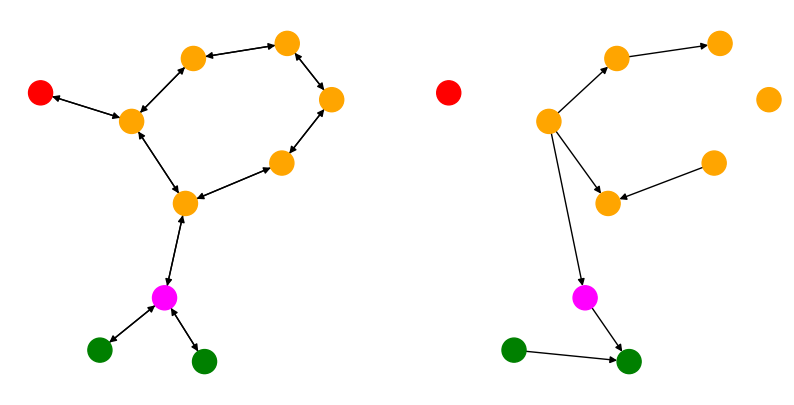

In [49]:
# Like figure 5 on page 9.

test_graph_0 = pyg.data.Batch.from_data_list([test_data_list_0[8]])
print(torch.softmax(explainee(test_graph_0), dim=-1))

noised_graph = forward_diffusion_sample(test_graph_0, torch.tensor([T-1])) 
_, pred_graph = model_denoise_CF(noised_graph, torch.tensor([T-1]))
print(torch.softmax(explainee(pred_graph), dim=-1))
pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)

test_graph_0.edge_index = pygm.utils.dense_to_sparse(
    test_graph_0.edge_attr.reshape(max_num_nodes, max_num_nodes)
)[0].transpose(0, 1)
test_graph_0 = clean_graph(test_graph_0)
test_graph_0_colors = color_palette[torch.argmax(test_graph_0.x, dim=1)]
test_graph_0_nx = pyg.utils.to_networkx(test_graph_0)

pred_graph.edge_index = pygm.utils.dense_to_sparse(
    pred_graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
)[0].transpose(0, 1)
# Get non-zero padded nodes.
pred_graph = pred_graph.subgraph(torch.arange(test_graph_0.num_nodes))
#pred_graph = clean_graph(pred_graph)
pred_graph_colors = color_palette[torch.argmax(pred_graph.x, dim=1)]
pred_graph_nx = pyg.utils.to_networkx(pred_graph)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pos = nx.spring_layout(test_graph_0_nx)
nx.draw(test_graph_0_nx, node_color=test_graph_0_colors, 
        pos=pos, ax=axes[0])
nx.draw(pred_graph_nx, node_color=pred_graph_colors, 
        pos=pos, ax=axes[1])

tensor([[0.0429, 0.9571]], grad_fn=<SoftmaxBackward0>)
tensor([[0.9624, 0.0376]], grad_fn=<SoftmaxBackward0>)


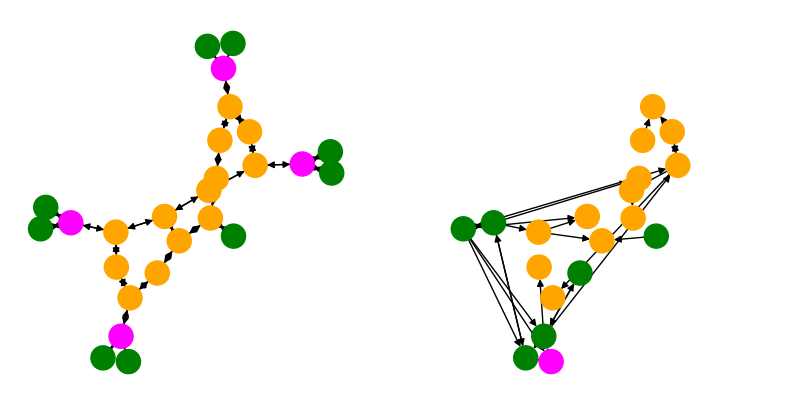

In [51]:
# Like figure 5 on page 9.

test_graph_1 = pyg.data.Batch.from_data_list([test_data_list_1[9]]) 
print(torch.softmax(explainee(test_graph_1), dim=-1))

noised_graph = forward_diffusion_sample(test_graph_1, torch.tensor([T-1])) 
_, pred_graph = model_denoise_CF(noised_graph, torch.tensor([T-1]))
print(torch.softmax(explainee(pred_graph), dim=-1))
pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)

test_graph_1.edge_index = pygm.utils.dense_to_sparse(
    test_graph_1.edge_attr.reshape(max_num_nodes, max_num_nodes)
)[0].transpose(0, 1)
test_graph_1 = clean_graph(test_graph_1)
test_graph_1_colors = color_palette[torch.argmax(test_graph_1.x, dim=1)]
test_graph_1_nx = pyg.utils.to_networkx(test_graph_1)

pred_graph.edge_index = pygm.utils.dense_to_sparse(
    pred_graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
)[0].transpose(0, 1)
# Get non-zero padded nodes.
pred_graph = pred_graph.subgraph(torch.arange(test_graph_1.num_nodes))
pred_graph = clean_graph(pred_graph)
pred_graph_colors = color_palette[torch.argmax(pred_graph.x, dim=1)]
pred_graph_nx = pyg.utils.to_networkx(pred_graph)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
pos = nx.spring_layout(test_graph_1_nx)
nx.draw(test_graph_1_nx, node_color=test_graph_1_colors, 
        pos=pos, ax=axes[0])
nx.draw(pred_graph_nx, node_color=pred_graph_colors, 
        pos=pos, ax=axes[1])

In [17]:
# Prediction Intervals

pred_prob_0 = []
for i in range(1000):
    idx = torch.randint(low=0, high=len(test_data_list_1), size=(1,)).item()
    test_graph = copy.deepcopy(test_data_list_1[idx])
    noised_graph = forward_diffusion_sample(test_graph, 
                                            torch.tensor([T-1]))
    _, pred_graph = model_denoise_CF(noised_graph, torch.tensor([T-1]))
    #pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)
    pred = F.softmax(explainee(pred_graph), dim=-1)[:, 0].item()
    pred_prob_0.append(pred)

pred_prob_0 = np.array(pred_prob_0)
mean_prob_0 = np.mean(pred_prob_0)
sd_prob_0 = np.std(pred_prob_0)
print(f"Mut_to_Non: {mean_prob_0} +/- {sd_prob_0}")

pred_prob_1 = []
for i in range(1000):
    idx = torch.randint(low=0, high=len(test_data_list_0), size=(1,)).item()
    test_graph = copy.deepcopy(test_data_list_0[idx])
    noised_graph = forward_diffusion_sample(test_graph, 
                                            torch.tensor([T-1]))
    _, pred_graph = model_denoise_CF(noised_graph, torch.tensor([T-1]))
    #pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)
    pred = F.softmax(explainee(pred_graph), dim=-1)[:, 1].item()
    pred_prob_1.append(pred)

pred_prob_1 = np.array(pred_prob_1)
mean_prob_1 = np.mean(pred_prob_1)
sd_prob_1 = np.std(pred_prob_1)
print(f"None_to_Mut: {mean_prob_1} +/- {sd_prob_1}")

Mut_to_Non: 0.6281943284673617 +/- 0.2251905092025937
None_to_Mut: 0.6592035529091954 +/- 0.20009966779565339


In [18]:
# Density Intervals

density_0 = []
for i in range(1000):
    idx = torch.randint(low=0, high=len(test_data_list_1), size=(1,)).item()
    test_graph = copy.deepcopy(test_data_list_1[idx])
    noised_graph = forward_diffusion_sample(test_graph, 
                                            torch.tensor([T-1]))
    _, pred_graph = model_denoise_CF(noised_graph, torch.tensor([T-1]))
    pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)

    test_graph.edge_index = pygm.utils.dense_to_sparse(
        test_graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
    )[0].transpose(0, 1)
    test_graph = clean_graph(test_graph)

    pred_graph.edge_index = pygm.utils.dense_to_sparse(
        pred_graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
    )[0].transpose(0, 1)
    # Get non-zero padded nodes.
    pred_graph = pred_graph.subgraph(torch.arange(test_graph_0.num_nodes))
    pred_graph = clean_graph(pred_graph)

    density = pred_graph.edge_index.shape[1] / (pred_graph.x.shape[0] ** 2)
    density_0.append(density)

density_0 = np.array(density_0)
mean_density_0 = np.mean(density_0)
sd_density_0 = np.std(density_0)
print(f"Mut_to_Non: {mean_density_0} +/- {sd_density_0}")

density_1 = []
for i in range(1000):
    idx = torch.randint(low=0, high=len(test_data_list_0), size=(1,)).item()
    test_graph = copy.deepcopy(test_data_list_0[idx])
    noised_graph = forward_diffusion_sample(test_graph, 
                                            torch.tensor([T-1]))
    _, pred_graph = model_denoise_CF(noised_graph, torch.tensor([T-1]))
    pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)

    test_graph.edge_index = pygm.utils.dense_to_sparse(
        test_graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
    )[0].transpose(0, 1)
    test_graph = clean_graph(test_graph)

    pred_graph.edge_index = pygm.utils.dense_to_sparse(
        pred_graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
    )[0].transpose(0, 1)
    # Get non-zero padded nodes.
    pred_graph = pred_graph.subgraph(torch.arange(test_graph_0.num_nodes))
    pred_graph = clean_graph(pred_graph)

    density = pred_graph.edge_index.shape[1] / (pred_graph.x.shape[0] ** 2)
    density_1.append(density)

density_1 = np.array(density_1)
mean_density_1 = np.mean(density_1)
sd_density_1 = np.std(density_1)
print(f"Non_to_Mut: {mean_density_1} +/- {sd_density_1}")

Mut_to_Non: 0.12848307004283196 +/- 0.031827394681718774
Non_to_Mut: 0.12906032942806753 +/- 0.029351315363903684


In [19]:
# Table 2 on page 8.

graph_ref_list_0 = []
for graph in train_data_list_0:
    graph_ref = pyg.data.Batch.from_data_list([graph])
    graph_ref = graph_to_nx(graph_ref)
    graph_ref = graph_ref.to_undirected()
    graph_ref_list_0.append(graph_ref)

graph_pred_list_0 = []
for test_graph in train_data_list_1:
    graph = copy.deepcopy(test_graph)
    noised_graph = forward_diffusion_sample(graph, torch.tensor([T-1])) 
    _, pred_graph = model_denoise_CF(noised_graph, torch.tensor([T-1]))
    pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)

    # Remove zero pad nodes.  
    graph.edge_index = pygm.utils.dense_to_sparse(
        graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
    )[0].transpose(0, 1)
    graph = clean_graph(graph)

    pred_graph.edge_index = pygm.utils.dense_to_sparse(
        pred_graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
    )[0].transpose(0, 1)
    pred_graph = pred_graph.subgraph(torch.arange(graph.num_nodes))

    # Clear isolated nodes and self-loops.
    pred_graph = clean_graph(pred_graph)
    pred_graph = pyg.utils.to_networkx(pred_graph)
    pred_graph = pred_graph.to_undirected()
    graph_pred_list_0.append(pred_graph)

deg_mmd_0 = D4Explainer.degree_stats(
    graph_ref_list_0, graph_pred_list_0
)

clus_mmd_0 = D4Explainer.clustering_stats(
    graph_ref_list_0, graph_pred_list_0
)

spec_mmd_0 = D4Explainer.spectral_stats(
   graph_ref_list_0, graph_pred_list_0 
)

print(f"deg_mmd_0: {deg_mmd_0}")
print(f"clus_mmd_0: {clus_mmd_0}")
print(f"spec_mmd_0: {spec_mmd_0}")

deg_mmd_0: 0.2746450807062244
clus_mmd_0: 0.565774694754088
spec_mmd_0: 0.04785762320887979


In [20]:
# Table 2 on page 8.

graph_ref_list_1 = []
for graph in train_data_list_1:
    graph_ref = pyg.data.Batch.from_data_list([graph])
    graph_ref = graph_to_nx(graph_ref)
    graph_ref = graph_ref.to_undirected()
    graph_ref_list_1.append(graph_ref)

graph_pred_list_1 = []
for test_graph in train_data_list_0:
    graph = copy.deepcopy(test_graph)
    noised_graph = forward_diffusion_sample(graph, torch.tensor([T-1])) 
    _, pred_graph = model_denoise_CF(noised_graph, torch.tensor([T-1]))
    pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)

    # Remove zero pad nodes.  
    graph.edge_index = pygm.utils.dense_to_sparse(
        graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
    )[0].transpose(0, 1)
    graph = clean_graph(graph)

    pred_graph.edge_index = pygm.utils.dense_to_sparse(
        pred_graph.edge_attr.reshape(max_num_nodes, max_num_nodes)
    )[0].transpose(0, 1)
    pred_graph = pred_graph.subgraph(torch.arange(graph.num_nodes))

    # Clear isolated nodes and self-loops.
    pred_graph = clean_graph(pred_graph)
    pred_graph = pyg.utils.to_networkx(pred_graph)
    pred_graph = pred_graph.to_undirected()
    graph_pred_list_1.append(pred_graph)

deg_mmd_1 = D4Explainer.degree_stats(
    graph_ref_list_1, graph_pred_list_1
)

clus_mmd_1 = D4Explainer.clustering_stats(
    graph_ref_list_1, graph_pred_list_1
)

spec_mmd_1 = D4Explainer.spectral_stats(
   graph_ref_list_1, graph_pred_list_1 
)

print(f"deg_mmd_1: {deg_mmd_1}")
print(f"clus_mmd_1: {clus_mmd_1}")
print(f"spec_mmd_1: {spec_mmd_1}")

deg_mmd_1: 0.08104155817111236
clus_mmd_1: 0.24915511959631176
spec_mmd_1: 0.04094986663914385


### Extras

In [21]:
# Training Loop.
model_denoise= denoising_model(T, time_embed_dim=time_embed_dim, 
                                num_node_feats=num_node_feats) 

optimizer = torch.optim.Adam(model_denoise.parameters(), lr=0.001)
CF_weight = 0.0

for epoch in range(1, num_epochs): 
    running_loss_dist = 0.0
    running_loss_CF = 0.0
    for graphs in train_loader:
        with torch.no_grad():
            t = torch.randint(low=1, high=T, size=(1,))
            noised_graphs = forward_diffusion_sample(graphs, t)

        pred_weight, pred_graph = model_denoise(noised_graphs, t)

        loss_dist = F.binary_cross_entropy(
            pred_weight, graphs.edge_attr.squeeze(1)
        )  
        running_loss_dist += loss_dist.item()

        explainee.eval()
        explainee_pred = F.softmax(explainee(pred_graph), dim=-1)
        class_prob = explainee_pred[torch.arange(explainee_pred.shape[0]), 
                                    graphs.y]
        loss_CF = (-1 * torch.log(1 - class_prob)).mean()
        running_loss_CF += loss_CF.item()

        loss = 1.0 * loss_dist + CF_weight * loss_CF
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(
        f"Epoch: {epoch}", 
        f" Loss_dist: {running_loss_dist / len(train_loader)}", 
        f" Loss_CF: {running_loss_CF / len(train_loader)}"
    )

Epoch: 1  Loss_dist: 0.6939517656962076  Loss_CF: 1.8853321075439453
Epoch: 2  Loss_dist: 0.6909194986025492  Loss_CF: 1.7986430724461873
Epoch: 3  Loss_dist: 0.6836826403935751  Loss_CF: 1.8148048718770344
Epoch: 4  Loss_dist: 0.6737126111984253  Loss_CF: 1.8528076807657878
Epoch: 5  Loss_dist: 0.6666280825932821  Loss_CF: 1.8432851235071819
Epoch: 6  Loss_dist: 0.657514750957489  Loss_CF: 1.7798505624135335
Epoch: 7  Loss_dist: 0.6399077574412028  Loss_CF: 1.8310389121373494
Epoch: 8  Loss_dist: 0.6238972942034403  Loss_CF: 1.9300966262817383
Epoch: 9  Loss_dist: 0.6219194730122884  Loss_CF: 1.760024905204773
Epoch: 10  Loss_dist: 0.6073268453280131  Loss_CF: 1.7398382425308228
Epoch: 11  Loss_dist: 0.5890134572982788  Loss_CF: 1.8984062274297078
Epoch: 12  Loss_dist: 0.5734653472900391  Loss_CF: 1.7391311327616374
Epoch: 13  Loss_dist: 0.5699378053347269  Loss_CF: 1.7795825401941936
Epoch: 14  Loss_dist: 0.5478850801785787  Loss_CF: 1.6836208899815877
Epoch: 15  Loss_dist: 0.5538602

In [22]:
def model_level_sampling(N: int, K:int, target: int):
    # Sample random adjacency matrix.
    rand_weight = torch.zeros((K, max_num_nodes, max_num_nodes))
    for batch in range(K):
        idx = [(i, j) for i in range(max_num_nodes) for j in range(max_num_nodes)]
        rand_idx = torch.randperm(len(idx))[:N**2]
        for i in rand_idx:
            i, j = idx[i]
            rand_weight[batch, i, j] = 0.5
    Gr_T = torch.bernoulli(rand_weight).view(-1, 1).squeeze(-1)
    #Gr_T = pyg.utils.erdos_renyi_graph(N, 0.5, directed=True)

    # Combine with observed node features.
    features = pyg.data.Batch.from_data_list(
        test_data_list[:K]
    )
    Gr_T = pyg.data.Data(
        x=features.x, edge_index=features.edge_index, edge_attr=Gr_T, 
        batch=features.batch
    )

    for t in range(T-1, 0, -1):
        # Sample candidates.
        pred_weight, G0_K = model_denoise(Gr_T, torch.tensor([t]))
        # Compute probabilities. 
        probs = F.softmax(explainee(G0_K), dim=-1)[:, target]
        j = torch.argmax(probs)
        pred_weight = pred_weight.reshape(K, max_num_nodes, max_num_nodes)
        G0_j = torch.bernoulli(pred_weight[j, :, :]).view(-1, 1).squeeze(-1)
        G0_j = pyg.data.Batch(
            x=features.x, edge_index=features.edge_index, 
            edge_attr=G0_j.repeat(K), 
            batch=features.batch
        )

        Gr_T = forward_diffusion_sample(G0_j, torch.tensor([t-1]))
    
    return Gr_T

In [23]:
Gr_0 = model_level_sampling(30, 30, 0)
F.softmax(explainee(Gr_0), dim=-1)

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], grad_fn=<SoftmaxBackward0>)

## GNNInterpreter  

In [24]:
class generator_model(nn.Module):
    def __init__(self, max_nodes: int, num_cats: int, batch_size:int, 
                 temp=1.0):
        super(generator_model, self).__init__()
        
        self.max_nodes = max_nodes
        self.num_cats = num_cats
        self.batch_size = batch_size
        self.temp = temp

        self.theta_cat = nn.Parameter(
            nn.init.uniform_(
                torch.Tensor(max_nodes, num_cats), 
                0.0, 1.0
            ).squeeze(0)
        ) 

        self.theta_A = nn.Parameter(
            nn.init.uniform_(
                torch.empty((max_nodes, max_nodes)), 
                0.0, 1.0
            )
        )
    
    def forward(self) -> pyg.data.Batch:
        node_dist = td.RelaxedOneHotCategorical(
            self.temp, probs=torch.softmax(self.theta_cat, dim=-1), 
            validate_args=False
        ) 
        sample_nodes = node_dist.rsample(
            (self.batch_size, )
        )

        self.theta_A.data.fill_diagonal_(0.0) # no self-loops.
        self.theta_A.data.clamp_(0.0, 1.0)
        # nan_mask = torch.isnan(self.theta_A)
        # self.theta_A.data = torch.where(
        #     nan_mask, torch.tensor(0.0, device=self.theta_A.device), 
        #     self.theta_A.data
        # )
        # print(self.theta_A)
        edge_dist = td.RelaxedBernoulli(
            self.temp, probs=self.theta_A
        )            
        sample_edges = edge_dist.rsample(
            (self.batch_size, )
        )
        full_edge_index, edge_weight, _ = pygm.utils.dense_to_sparse(
            sample_edges + 1
        )
        full_edge_index = full_edge_index.transpose(1, 2)
        edge_weight = edge_weight - 1

        data_list = [
            pyg.data.Data(x=X, edge_index=A, 
                          edge_attr=E) 
            for (X, A, E) in zip(
                sample_nodes.unbind(), full_edge_index.unbind(), 
                edge_weight.unbind()
            )
        ]

        return pyg.data.Batch.from_data_list(data_list)

In [25]:
def dict_cos_dist(dict1: Dict[str, torch.Tensor], 
                  dict2: Dict[str, torch.Tensor], 
                  batch_indices1: torch.Tensor, 
                  batch_indices2=None,  
                  act_pool_func: Callable=pyg.nn.global_mean_pool, 
                  expand2=True, 
                  agg_func: Callable=torch.mean, 
                  batch_size=None):
    """
    Returns the aggregated cosine distance by batch between two dictionaries 
    of tensors on matching keys. 
    Tensors contribute 2 if opposite, 1 is orthogonal, and 0 is same. 
    """
    agg_cos_dist = []
    for key in set(dict1.keys()) & set(dict2.keys()): 
        tensor1 = act_pool_func(dict1[key], 
                                batch=batch_indices1, size=batch_size)
        if expand2: 
            tensor2 = dict2[key].expand_as(tensor1).to(tensor1.device)
        else: 
            tensor2 = act_pool_func(dict2[key], 
                                    batch=batch_indices2, size=batch_size)

        cos_sim = F.cosine_similarity(tensor1, tensor2, dim=1)

        agg_cos_dist.append(1 - cos_sim) # [B]

    assert torch.all(agg_func(torch.stack(agg_cos_dist), dim=0) >= -1e-5)
    
    return agg_func(torch.stack(agg_cos_dist), dim=0)

class gnnIntLoss(nn.Module):
    def __init__(self, target: torch.tensor, avg_embeddings: Dict, 
                 budget: int):
        super(gnnIntLoss, self).__init__()
        self.avg_embeddings = avg_embeddings
        self.target = target
        self.budget = budget
    
    def forward(self, batch, edge_weights, num_nodes):

        activations, remove_hooks = (
            activation_hook(explainee, self.avg_embeddings.keys())
        ) 
        explainee_pred = F.softmax(explainee(batch), dim=-1)

        loss_pred = F.binary_cross_entropy(
            explainee_pred, 
            self.target.expand_as(explainee_pred).to(explainee_pred.device)
        )
        
        loss_embed = dict_cos_dist(activations, self.avg_embeddings, 
                                    batch_indices1=batch.batch).mean()
        loss_sparsity = (
            edge_weights.norm(p=2) + 
            edge_weights.norm(p=1) + 
            (F.softplus(edge_weights.sum() - self.budget, beta=1)) ** 2
        )

        # loss_sparsity = (torch.norm(edge_weights, p=1) + 
        #                  torch.norm(edge_weights, p=2) + 
        #                  (F.softplus(torch.norm(edge_weights, p=1)) - 
        #                   self.budget)**2)
        #loss_sparsity = loss_sparsity

        # loss_connect = torch.zeros(batch.num_graphs)
        # edge_probs = edge_weights.reshape(
        #     batch.num_graphs, num_nodes, num_nodes
        # )
        # for batch_idx in range(batch.num_graphs):
        #     kl_sum = 0.0

        #     for row_idx in range(num_nodes):
        #         p = edge_probs[batch_idx, row_idx, 0]

        #         for col_idx in range(1, num_nodes):
        #             q = edge_probs[batch_idx, row_idx, col_idx]

        #             #kl_div = F.kl_div(q.log(), p, reduction='sum')
        #             kl_div = F.binary_cross_entropy(q, p, reduction='sum')
        #             kl_sum += kl_div

        #     loss_connect[batch_idx] = kl_sum
        
        # loss_connect = loss_connect.mean()
    
        return torch.stack([loss_pred, loss_embed, loss_sparsity])

In [26]:
max_nodes = 8
batch_size = 100

In [27]:
# training loop 
gen_0 = generator_model(max_nodes=max_nodes, num_cats=7, 
                        batch_size=batch_size, temp=0.15)
gen_0.train()
optimizer = torch.optim.RMSprop(gen_0.parameters())

loss_fn = gnnIntLoss(target = torch.tensor([1.0, 0.0]), 
                     avg_embeddings=train_avg_embedding_0, budget=10)

for epoch in range(1, 201): 
    G_gen = gen_0()

    loss = loss_fn(G_gen, G_gen.edge_attr, 20)
    print(f"Epoch: {epoch}, Loss: {loss}")
    loss_weights = torch.tensor([1.0, 1.0, 5e-8])
    loss = loss_weights @ loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(gen_0.parameters(), 1.0)

    optimizer.step()
    optimizer.zero_grad()

Epoch: 1, Loss: tensor([1.1066e+01, 7.1343e-01, 7.2973e+06], grad_fn=<StackBackward0>)
Epoch: 2, Loss: tensor([6.4977e+00, 6.7599e-01, 8.0568e+06], grad_fn=<StackBackward0>)
Epoch: 3, Loss: tensor([7.8680e+00, 6.7950e-01, 8.3728e+06], grad_fn=<StackBackward0>)
Epoch: 4, Loss: tensor([6.2701e+00, 6.5254e-01, 8.5605e+06], grad_fn=<StackBackward0>)
Epoch: 5, Loss: tensor([7.7899e+00, 6.3616e-01, 8.8951e+06], grad_fn=<StackBackward0>)
Epoch: 6, Loss: tensor([6.8082e+00, 6.7408e-01, 8.9249e+06], grad_fn=<StackBackward0>)
Epoch: 7, Loss: tensor([5.5798e+00, 5.9486e-01, 8.9742e+06], grad_fn=<StackBackward0>)
Epoch: 8, Loss: tensor([4.4037e+00, 5.9643e-01, 8.9477e+06], grad_fn=<StackBackward0>)
Epoch: 9, Loss: tensor([6.4350e+00, 6.2736e-01, 8.6339e+06], grad_fn=<StackBackward0>)
Epoch: 10, Loss: tensor([2.7214e+00, 5.7185e-01, 8.7205e+06], grad_fn=<StackBackward0>)
Epoch: 11, Loss: tensor([3.7197e+00, 5.9886e-01, 8.5385e+06], grad_fn=<StackBackward0>)
Epoch: 12, Loss: tensor([1.8205e+00, 5.29

In [28]:
# training loop 
gen_1 = generator_model(max_nodes=max_nodes, num_cats=7, 
                        batch_size=batch_size, temp=0.15)
gen_1.train()
optimizer = torch.optim.RMSprop(gen_1.parameters())

loss_fn = gnnIntLoss(target = torch.tensor([0.0, 1.0]), 
                     avg_embeddings=train_avg_embedding_1, budget=10)

for epoch in range(1, 201): 
    G_gen = gen_1()

    loss = loss_fn(G_gen, G_gen.edge_attr, 20)
    print(f"Epoch: {epoch}, Loss: {loss}")
    loss_weights = torch.tensor([1.0, 10.0, 5e-8])
    loss = loss_weights @ loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(gen_1.parameters(), 1.0)

    optimizer.step()
    optimizer.zero_grad()

Epoch: 1, Loss: tensor([8.7442e-01, 4.0545e-01, 5.6458e+06], grad_fn=<StackBackward0>)
Epoch: 2, Loss: tensor([3.7577e-01, 2.2184e-01, 5.5979e+06], grad_fn=<StackBackward0>)
Epoch: 3, Loss: tensor([5.4689e-01, 2.7480e-01, 5.1855e+06], grad_fn=<StackBackward0>)
Epoch: 4, Loss: tensor([2.9238e-01, 1.9437e-01, 4.8482e+06], grad_fn=<StackBackward0>)
Epoch: 5, Loss: tensor([3.8097e-01, 1.9490e-01, 5.1772e+06], grad_fn=<StackBackward0>)
Epoch: 6, Loss: tensor([5.3329e-01, 2.3542e-01, 5.3633e+06], grad_fn=<StackBackward0>)
Epoch: 7, Loss: tensor([8.4115e-01, 1.6218e-01, 5.0330e+06], grad_fn=<StackBackward0>)
Epoch: 8, Loss: tensor([3.3068e-01, 1.5397e-01, 5.1336e+06], grad_fn=<StackBackward0>)
Epoch: 9, Loss: tensor([2.1479e-01, 1.5653e-01, 5.5722e+06], grad_fn=<StackBackward0>)
Epoch: 10, Loss: tensor([3.6515e-01, 2.3079e-01, 5.3329e+06], grad_fn=<StackBackward0>)
Epoch: 11, Loss: tensor([3.0049e-01, 2.0347e-01, 5.1124e+06], grad_fn=<StackBackward0>)
Epoch: 12, Loss: tensor([1.7029e-01, 1.34

In [29]:
# Prediction Intervals
pred_prob_0 = []
for i in range(10):
    pred_graph = gen_0()
    pred = F.softmax(explainee(pred_graph), dim=-1)[:, 0].mean().item()
    pred_prob_0.append(pred)

pred_prob_0 = np.array(pred_prob_0)
mean_prob_0 = np.mean(pred_prob_0)
sd_prob_0 = np.std(pred_prob_0)
print(f"Non: {mean_prob_0} +/- {sd_prob_0}")

pred_prob_1 = []
for i in range(10):
    pred_graph = gen_1()
    pred = F.softmax(explainee(pred_graph), dim=-1)[:, 1].mean().item()
    pred_prob_1.append(pred)

pred_prob_1 = np.array(pred_prob_1)
mean_prob_1 = np.mean(pred_prob_1)
sd_prob_1 = np.std(pred_prob_1)
print(f"Mut: {mean_prob_1} +/- {sd_prob_1}")

Non: 0.9336315929889679 +/- 0.011779745441381018
Mut: 0.979236263036728 +/- 0.010234629633227216


In [30]:
# Density Intervals
density_0 = []
for i in range(10): 
    pred_graph = gen_0()

    pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)
    pred_graph.edge_index = pyg.utils.dense_to_sparse(
        pred_graph.edge_attr.reshape(batch_size, max_nodes, max_nodes)
    )[0]
    pred_graph = clean_graph(pred_graph)

    density = (pred_graph.edge_index.shape[1] / (pred_graph.x.shape[0] ** 2 
                                                 / batch_size))
    density_0.append(density)

density_0 = np.array(density_0)
mean_density_0 = np.mean(density_0)
sd_density_0 = np.std(density_0)
print(f"Non: {mean_density_0} +/- {sd_density_0}")

density_1 = []
for i in range(10): 
    pred_graph = gen_1()

    pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)
    pred_graph.edge_index = pyg.utils.dense_to_sparse(
        pred_graph.edge_attr.reshape(batch_size, max_nodes, max_nodes)
    )[0]
    pred_graph = clean_graph(pred_graph)

    density = pred_graph.edge_index.shape[1] / (pred_graph.x.shape[0] ** 2 
                                                / batch_size)
    density_1.append(density)

density_1 = np.array(density_1)
mean_density_1 = np.mean(density_1)
sd_density_1 = np.std(density_1)
print(f"Mut: {mean_density_1} +/- {sd_density_1}")

Non: 0.38323437499999996 +/- 0.0023469249328909076
Mut: 0.31964225889174674 +/- 0.003153597728529088


In [31]:
# MMD
graph_ref_list_0 = []
for graph in train_data_list_0:
    graph_ref = pyg.data.Batch.from_data_list([graph])
    graph_ref = graph_to_nx(graph_ref)
    graph_ref = graph_ref.to_undirected()
    graph_ref_list_0.append(graph_ref)

graph_pred_list_0 = []
pred_graph = gen_0()

pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)
pred_graph.edge_index = pyg.utils.dense_to_sparse(
    pred_graph.edge_attr.reshape(batch_size, max_nodes, max_nodes)
)[0]
pred_graph = clean_graph(pred_graph)

data_list = to_data_list(pred_graph)
data_list = [
    pyg.utils.to_networkx(data).to_undirected() 
    for data in data_list
]
graph_pred_list_0 += data_list 

deg_mmd_0 = D4Explainer.degree_stats(
    graph_ref_list_0, graph_pred_list_0
)

clus_mmd_0 = D4Explainer.clustering_stats(
    graph_ref_list_0, graph_pred_list_0
)

spec_mmd_0 = D4Explainer.spectral_stats(
   graph_ref_list_0, graph_pred_list_0 
)

print(f"deg_mmd_0: {deg_mmd_0}")
print(f"clus_mmd_0: {clus_mmd_0}")
print(f"spec_mmd_0: {spec_mmd_0}")

deg_mmd_0: 1.7743778229614353
clus_mmd_0: 1.5321120650853735
spec_mmd_0: 0.06606161095813778


In [32]:
graph_ref_list_1 = []
for graph in train_data_list_1:
    graph_ref = pyg.data.Batch.from_data_list([graph])
    graph_ref = graph_to_nx(graph_ref)
    graph_ref = graph_ref.to_undirected()
    graph_ref_list_1.append(graph_ref)

graph_pred_list_1 = []
pred_graph = gen_1()

pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)
pred_graph.edge_index = pyg.utils.dense_to_sparse(
    pred_graph.edge_attr.reshape(batch_size, max_nodes, max_nodes)
)[0]
pred_graph = clean_graph(pred_graph)

data_list = to_data_list(pred_graph)
data_list = [
    pyg.utils.to_networkx(data).to_undirected() 
    for data in data_list
]
graph_pred_list_1 += data_list 

deg_mmd_1 = D4Explainer.degree_stats(
    graph_ref_list_1, graph_pred_list_1
)

clus_mmd_1 = D4Explainer.clustering_stats(
    graph_ref_list_1, graph_pred_list_1
)

spec_mmd_1 = D4Explainer.spectral_stats(
   graph_ref_list_1, graph_pred_list_1 
)

print(f"deg_mmd_1: {deg_mmd_1}")
print(f"clus_mmd_1: {clus_mmd_1}")
print(f"spec_mmd_1: {spec_mmd_1}")

deg_mmd_1: 1.4100169855578542
clus_mmd_1: 1.438633023284394
spec_mmd_1: 0.035000361630776175


tensor([[0.9436, 0.0564]], grad_fn=<SoftmaxBackward0>)


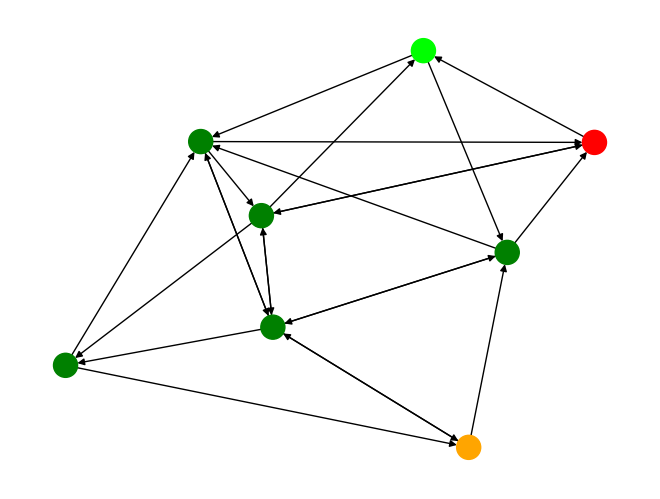

In [33]:
# Visual 0
pred_graph = gen_0()

pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)
pred_graph.edge_index = pyg.utils.dense_to_sparse(
    pred_graph.edge_attr.reshape(batch_size, max_nodes, max_nodes)
)[0]
pred_graph = clean_graph(pred_graph)
pred_graph = to_data_list(pred_graph)[0]
print(F.softmax(explainee(pred_graph), dim=-1))

pred_graph_colors = color_palette[torch.argmax(pred_graph.x, dim=1)]
pred_graph_nx = pyg.utils.to_networkx(pred_graph)

nx.draw(pred_graph_nx, node_color=pred_graph_colors)

tensor([[0.0022, 0.9978]], grad_fn=<SoftmaxBackward0>)


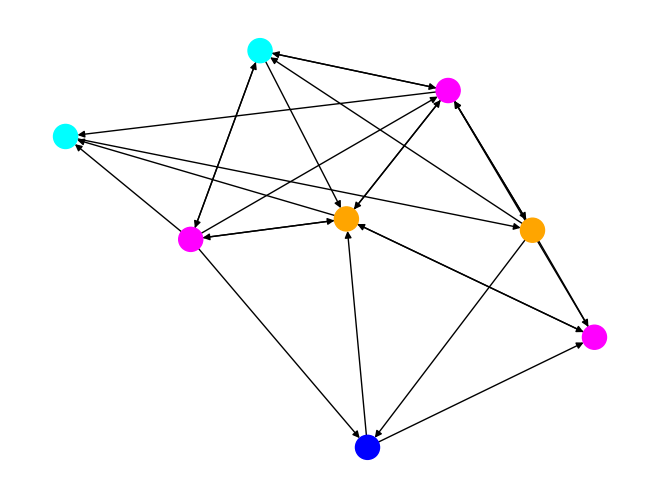

In [36]:
# Visual 1
pred_graph = gen_1()

pred_graph.edge_attr = torch.bernoulli(pred_graph.edge_attr)
pred_graph.edge_index = pyg.utils.dense_to_sparse(
    pred_graph.edge_attr.reshape(batch_size, max_nodes, max_nodes)
)[0]
pred_graph = clean_graph(pred_graph)
pred_graph = to_data_list(pred_graph)[0]
print(F.softmax(explainee(pred_graph), dim=-1))

pred_graph_colors = color_palette[torch.argmax(pred_graph.x, dim=1)]
pred_graph_nx = pyg.utils.to_networkx(pred_graph)

nx.draw(pred_graph_nx, node_color=pred_graph_colors)

# Debugging